In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.3 MB/s eta 0:00:00


In [2]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset
import math
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2Model

# df = pd.read_csv('/content/drive/MyDrive/training.csv')
# df.head()
df = pd.read_csv('/content/training.csv', sep =',')

print(df.head())

                                               Input Sentiment
0          I can't understand the method of teaching  Negative
1  The instructor was interested in the students ...  Positive
2  The instructor don't use any examples for expl...  Negative
3          Teaching is good but always late to class   Neutral
4                               Explaination is poor  Negative


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
df.columns

Index(['Input', 'Sentiment'], dtype='object')

In [5]:
X = df['Input']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [6]:
X_train

751                                       Great teaching
14                                       Right on target
80                  Gr8 lecturers with perfect knowledge
136     Can't handle the class full of too many students
730                                                Gr888
                             ...                        
624                                        Un scheduled 
803                                                Finee
459    what the instructor taught and what comes up i...
248                                Highly rated content.
425                                    Easy but not deep
Name: Input, Length: 976, dtype: object

In [7]:
MAX_LENGTH = math.ceil((X_train.apply(lambda x: len(str(x).split())).mean()))+2
MAX_LENGTH

6

In [8]:
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

# this will download and initialize the pre trained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",
    pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN,
    max_length=MAX_LENGTH,
    is_split_into_words=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
X_train = [str(ex) + EOS_TOKEN for ex in X_train]
X_test = [str(ex) + EOS_TOKEN for ex in X_test]

In [10]:
X_train_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_train]
X_test_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_test]

X_train_in = tf.squeeze(tf.convert_to_tensor(X_train_), axis=1)
X_test_in = tf.squeeze(tf.convert_to_tensor(X_test_), axis=1)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
X_train_in[0]

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([13681,  7743, 50256, 50257, 50257, 50257], dtype=int32)>

In [12]:
X_train_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_train]
X_test_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_test]

X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask_), axis=1)
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask_), axis=1)

In [13]:
model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
model.training = True

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [14]:
model.resize_token_embeddings(len(tokenizer))

In [15]:
for layer in model.layers:
    layer.trainable = False

In [16]:
model.summary()

Model: "tfgpt2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124440576 
 r)                                                              
                                                                 
Total params: 163,038,720
Trainable params: 38,598,144
Non-trainable params: 124,440,576
_________________________________________________________________


In [17]:
input = tf.keras.layers.Input(shape=(None,), dtype='int32')
mask = tf.keras.layers.Input(shape=(None,), dtype='int32')
x = model(input, attention_mask=mask)
#x = x.last_hidden_state[:, -1]
x = tf.reduce_mean(x.last_hidden_state, axis=1)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)

In [18]:
clf = tf.keras.Model([input, mask], output)

In [19]:
clf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tfgpt2_model (TFGPT2Model)     TFBaseModelOutputWi  124440576   ['input_1[0][0]',                
                                thPastAndCrossAtten               'input_2[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, None, 7                                           

In [20]:
base_learning_rate = 0.0005
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
#loss=tf.keras.losses.BinaryCrossentropy()
loss=tf.keras.losses.SparseCategoricalCrossentropy()

clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [21]:
callbacks = tf.keras.callbacks.EarlyStopping(
        monitor="accuracy", verbose=1, patience=5, restore_best_weights=True)

In [22]:
def map_sentiment(value):
  if value == 'Negative':
    return 0
  if value == 'Neutral':
    return 1
  if value == 'Positive':
    return 2

In [23]:
y_train_ = y_train.map(map_sentiment)
y_test_ = y_test.map(map_sentiment)

In [24]:
y_train_in = tf.constant(y_train_, dtype=tf.int32)
y_test_in = tf.constant(y_test_, dtype=tf.int32)

In [25]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [26]:
history = clf.fit([X_train_in, X_train_mask], y_train_in, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 10s 409ms/step - loss: 4.6220 - accuracy: 0.4218 - val_loss: 1.1400 - val_accuracy: 0.4694
Epoch 2/30
25/25 [==============================] - 18s 740ms/step - loss: 3.0133 - accuracy: 0.3885 - val_loss: 1.2104 - val_accuracy: 0.3673
Epoch 3/30
25/25 [==============================] - 11s 426ms/step - loss: 2.2856 - accuracy: 0.3731 - val_loss: 1.0800 - val_accuracy: 0.4031
Epoch 4/30
25/25 [==============================] - 10s 390ms/step - loss: 1.4148 - accuracy: 0.4385 - val_loss: 1.0303 - val_accuracy: 0.4694
Epoch 5/30
25/25 [==============================] - 10s 409ms/step - loss: 1.0376 - accuracy: 0.5064 - val_loss: 1.0399 - val_accuracy: 0.4847
Epoch 6/30
25/25 [==============================] - 9s 377ms/step - loss: 0.9868 - accuracy: 0.5244 - val_loss: 0.9531 - val_accuracy: 0.5612
Epoch 7/30
25/25 [==============================] - 11s 448ms/step - loss: 0.9752 - accuracy: 0.5372 - val_loss: 0.9435 - val_accuracy: 0.5510
Epoch 8/30


In [27]:
clf.evaluate([X_test_in, X_test_mask], y_test_in)

11/11 [==============================] - 1s 123ms/step - loss: 0.7604 - accuracy: 0.7055


[0.7603970170021057, 0.7055214643478394]

In [28]:
clf.training = False
y_pred = clf.predict([X_test_in, X_test_mask])

11/11 [==============================] - 1s 120ms/step


In [29]:
y_pred_out = tf.math.argmax(y_pred, axis=-1)
y_pred_out

<tf.Tensor: shape=(326,), dtype=int64, numpy=
array([0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 0,
       1, 2, 2, 0, 1, 0, 1, 0, 2, 2, 0, 2, 0, 2, 1, 0, 0, 2, 0, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 2,
       2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 1, 0, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2,
       2, 2, 0, 0, 2, 0, 1, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0,
       2, 2, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0,
       2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2,
     

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [31]:
print(classification_report(y_test_in, y_pred_out))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       124
           1       0.64      0.24      0.35        58
           2       0.71      0.85      0.77       144

    accuracy                           0.71       326
   macro avg       0.69      0.62      0.62       326
weighted avg       0.70      0.71      0.68       326



In [32]:
confusion_df = pd.DataFrame(confusion_matrix(y_test_in, y_pred_out))
confusion_df.index = ['Actual -1', 'Actual 0', 'Actual 1']
confusion_df.columns = ['Predicted -1', 'Predicted 0', 'Predicted 1']
confusion_df

,Predicted -1,Predicted 0,Predicted 1
Actual -1,94,6,24
Actual 0,17,14,27
Actual 1,20,2,122


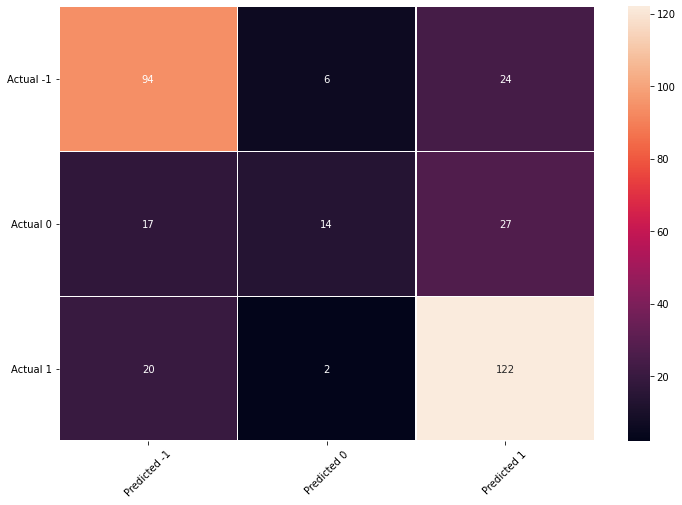

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_df, annot=True, fmt='d', linewidths=0.5) 
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()